In [1]:
# Libraries

# Operating System Interaction
import os # to interact with the operating system
import glob # to find files in directories

# Numerical and Data Handling
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import xarray as xr # for n-dimensional data manipulation

# Data Interpolation and Signal Processing
from scipy.interpolate import griddata # for data interpolation
from scipy import signal # for signal processing
import scipy.fftpack as fp # for fast fourier transforms

# Convolution Operations
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans # for convolution operations

# Plotting and Visualization 
import matplotlib.pyplot as plt # for plotting
import cartopy.crs as ccrs # for cartographic projections
import cartopy.feature as cfeature # for cartographic features
import cartopy # for cartographic projections
import xesmf as xe # for regridding

# Scientific Computing and Evaluation
import xskillscore # for model evaluation

# System and Performance Management
import sys # for system management
import gc # for garbage collection

# Parallel Computing (Commented Out)
#from dask import delayed, compute

# High Pass Filter

It allows high frequencies to pass while **removing low frequencies**.

$$\eta_{truth} \rightarrow  \eta_{truth} - \eta_{truth}^{BM}$$

## Loading Data

In [2]:
sshdedac = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_*.nc", combine="nested", concat_dim="time_counter", parallel=True)

In [3]:
# Calculate differences between adjacent latitudes (ignoring potential wrap-around issues)
lat_diffs = np.diff(sshdedac.nav_lat, axis=0)

# Estimate average resolution in latitude (degrees)
avg_lat_resolution = np.abs(lat_diffs).mean()

# Calculate differences between adjacent longitudes (ignoring potential wrap-around issues)
lon_diffs = np.diff(sshdedac.nav_lon, axis=1)

# Estimate average resolution in longitude (degrees)
avg_lon_resolution = np.abs(lon_diffs).mean()

print("Nominal Resolution: 1/60 [deg] (aprox. 0,01666666667) ")
print("Avg. Lat. Res.: ", avg_lat_resolution, "[deg]")
print("Ave. Lon. Res.: ", avg_lon_resolution, "[deg]")

Nominal Resolution: 1/60 [deg] (aprox. 0,01666666667) 
Avg. Lat. Res.:  0.01538049 [deg]
Ave. Lon. Res.:  0.016666647 [deg]


In [4]:
sshdedac = sshdedac.drop_vars(['latitude','longitude'])

# Rename nav_lat and nav_lon to lat and lon
sshdedac = sshdedac.rename({'nav_lat': 'lat', 'nav_lon': 'lon'})

# Since lat and lon are 2D coordinates, make sure to assign them properly to your dataset
sshdedac = sshdedac.assign_coords(lat=(('y', 'x'), sshdedac.lat.values),
                                  lon=(('y', 'x'), sshdedac.lon.values))

### Cropping for testing

In [5]:
sshdedac_cropped = sshdedac.where(
    (sshdedac.lat >= -22) & (sshdedac.lat <= -16) & 
    (sshdedac.lon >= 162) & (sshdedac.lon <= 168),
    drop=True
)

/home/riverama/.conda/envs/env-stage/lib/python3.11/site-packages/xarray/core/indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


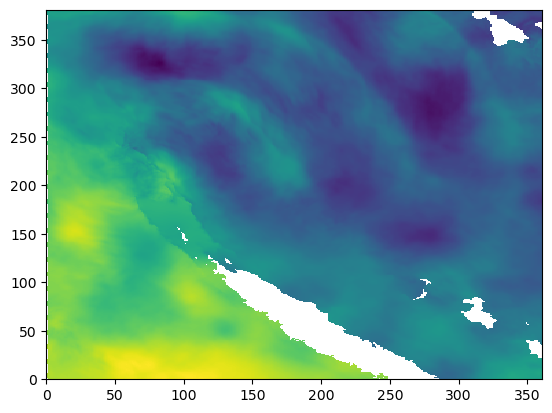

In [7]:
plt.pcolormesh(sshdedac_cropped.ssh_dedac[0,:,:])

In [10]:
sshdedac_cropped.to_netcdf("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/sshdedac_cropped_16_22_S_162_168_E.nc")

### Regriding

In [7]:
# # Define the target grid
# new_grid = xr.Dataset({
#     'lat': ('lat', np.arange(-90, 90, 0.02)),
#     'lon': ('lon', np.arange(-180, 180, 0.02)),
# })

# # Create a regridder
# regridder = xe.Regridder(ssh_dedac_cropped, new_grid, 'nearest_s2d') # Nearest neighbor sampling

# # Perform the regridding
# ssh_dedac_regridded = regridder(ssh_dedac_cropped.ssh_dedac)

In [ ]:
# ssh_dedac_regridded.to_netcdf("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_regridded_16_22_S_162_168_E.nc")

## Gaussian Kernel

The actual separation into BM and HF components involves applying the Gaussian filter to the [SSH - DAC]  data. In a nutshell, the BM is directly calculated by applying a rolling window operation followed by a dot product with the Gaussian weights, normalized by the sum of the weights.

In [5]:
sshdedac_cropped = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/sshdedac_cropped_16_22_S_162_168_E.nc")

In [6]:
# Assuming sshdedac_cropped is your Dataset
# And assuming the target coordinates are -19 (for 19S) and 165 (for 165E)

# First, calculate the squared distance from every point to the target
squared_diff = (sshdedac_cropped.lat + 19)**2 + (sshdedac_cropped.lon - 165)**2

# Now, find the 1D index of the minimum distance
# Note: This operation flattens the array, finds the index of the minimum value,
# and then converts it back to the original 2D index format
min_diff_index = np.unravel_index(squared_diff.argmin().values, squared_diff.shape)

# Use these indices to select the corresponding data from your dataset
# Assuming 'y' and 'x' are your spatial dimensions corresponding to lat and lon
sshdedac_19S_165E = sshdedac_cropped.isel(y=min_diff_index[0], x=min_diff_index[1])


In [7]:
sshdedac_19S_165E

<xarray.Dataset> Size: 140kB
Dimensions:       (time_counter: 8760)
Coordinates:
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Data variables:
    ssh_dedac     (time_counter) float64 70kB dask.array<chunksize=(8760,), meta=np.ndarray>

In [7]:
# Setting some variables for ease of use later on
longitude = sshdedac_19S_165E.lon.values
latitude = sshdedac_19S_165E.lat.values
time = sshdedac_19S_165E.time_counter.values
nt = time.size
ny = latitude.size
nx = longitude.size

### Coriolis Parameter

The Coriolis parameter, by $f$, is a factor that **describes** the effect of the Earth's rotation **on moving objects**. It is defined as:

$$ f = 2 \Omega \sin(\phi) $$

where:

- $\Omega$ is the angular velocity of the Earth's rotation (~7.292E-5 [rad/s] which is calculated from $2\pi$ over 86164, which is the time of a sideral year in seconds.)
- $\phi$ is the latitude of the location in question.

The Coriolis parameter varies with latitude, affecting the movement of objects differently depending on their location on the Earth's surface. It's zero at the Equator and increases/decreases in magnitude toward the poles. 

In [8]:
f = 2*(2*np.pi/86164)*np.sin(np.mean(np.deg2rad(latitude)))

### Coriolis Period

This equation gives the period of a pendulum oscillating freely under the influence of the Coriolis force at the given latitude.

$$T = \frac{2\pi}{f}$$

In [9]:
T = np.abs(2*np.pi/f) # Including absolute becase the periode has to be positive.

### The Gaussian Function

$$G(t) = \exp^{-\frac{t^2}{2\sigma^{2}}}$$

Where $G(t)$ is the weight given by the Gaussian Function at time $t$, $t$ is the time offset from the central point, and $\sigma$ is the standart deviation of $G(t)$. The latter is related to the coriolis period ($T$) and the temporal resolution and $\mathrm{d}t$ controls the spread of $G(t)$.

### Time window

It is the **array** time step to compute the kernel. The goal is to stablish a range of indices that spans from (-) ``window_len`` to (+) ``window_len`` (inclusive) to eventually weight the neighboring points along the Gaussian Function. It is symetric at 0 (the central point).

<span style="font-size:0.8em;">**What is an array?** A collection of items of same data type stored ar at a contiguous memory allocation.</span>

In [10]:
dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window (around )
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel 
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values 
ntw = time_window.size
weight = xr.DataArray(exp_window, dims=['window'])

## Calculating HF and BM (For a single point)

Some acronyms: **HF** : High Frequency, **BM** : Balanced Motions, **BAR** : Barotropic Tide, **IGW** : Internal Gravity Waves, and **IT** : Internal Tide.

In [11]:
sshdedac_19S_165E_da = sshdedac_19S_165E['ssh_dedac']

In [12]:
# Perform the rolling operation on the DataArray
rolling_sshdedac_19S_165E_da = sshdedac_19S_165E_da.rolling(time_counter=ntw, center=True).construct('window')
# Ensure your 'weight' DataArray is aligned properly with the dimensions of the rolling window
# It seems like 'weight' should be a 1-dimensional array with the same length as 'time_window'

In [13]:
# Use the dot method on the DataArray
ssh_bm = rolling_sshdedac_19S_165E_da .dot(weight, dims=['window']) / weight.sum()

In [22]:
ssh_bm

<xarray.DataArray (time_counter: 8760)> Size: 70kB
dask.array<truediv, shape=(8760,), dtype=float64, chunksize=(8759,), chunktype=numpy.ndarray>
Coordinates:
    lat           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon           float32 4B dask.array<chunksize=(), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...

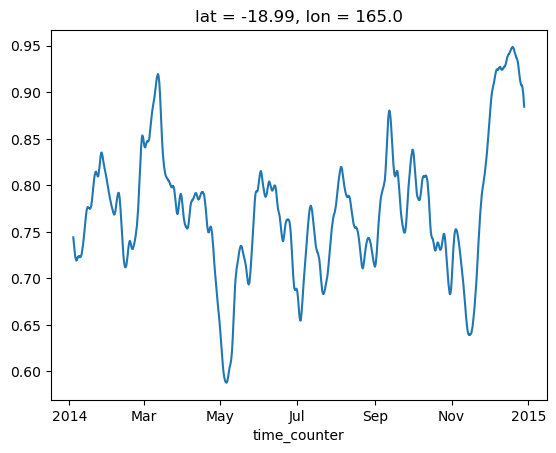

In [14]:
ssh_bm.plot()


In [15]:
ssh_hf = sshdedac_19S_165E_da - ssh_bm

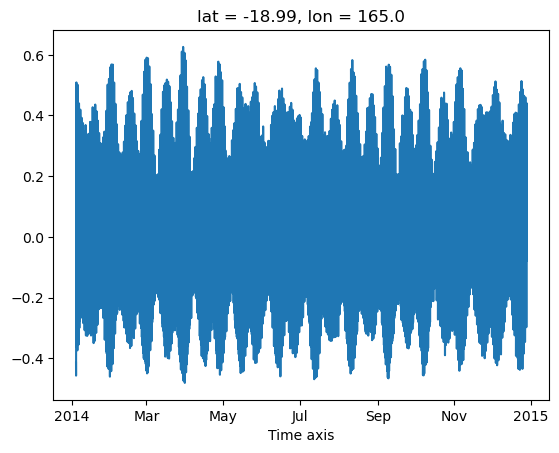

In [16]:
ssh_hf.plot()

## Calculating HF and BM (For a 2 degree area)

In [2]:
sshdedac_cropped = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/sshdedac_cropped_16_22_S_162_168_E.nc")

In [3]:
sshdedac_cropped

<xarray.Dataset> Size: 10GB
Dimensions:       (time_counter: 8760, y: 381, x: 361)
Coordinates:
    lat           (y, x) float32 550kB dask.array<chunksize=(381, 361), meta=np.ndarray>
    lon           (y, x) float32 550kB dask.array<chunksize=(381, 361), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (time_counter, y, x) float64 10GB dask.array<chunksize=(8760, 381, 361), meta=np.ndarray>

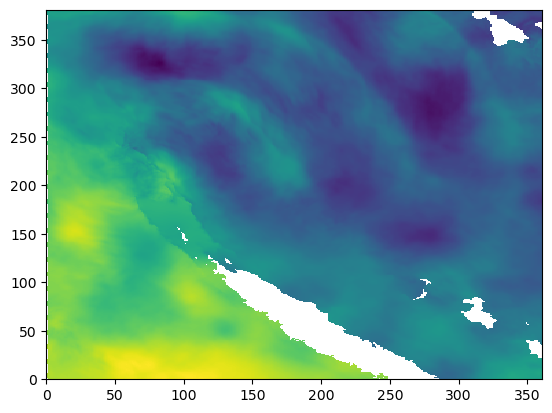

In [4]:
plt.pcolormesh(sshdedac_cropped.ssh_dedac[0,:,:])

In [12]:
# Assuming `sshdedac_cropped` is your original dataset
lat_condition = (sshdedac_cropped.lat >= -20) & (sshdedac_cropped.lat <= 18)  # Note the correction in latitude bounds
lon_condition = (sshdedac_cropped.lon >= 164) & (sshdedac_cropped.lon <= 166)

# Compute the conditions
lat_condition_computed = lat_condition.compute()
lon_condition_computed = lon_condition.compute()

# Apply the computed conditions - note, this step might need to be adjusted based on how your data is structured
sshdedac_cropped_18_20_S_164_166_E = sshdedac_cropped.where(
    lat_condition_computed & lon_condition_computed,
    drop=True
)

/home/riverama/.conda/envs/env-stage/lib/python3.11/site-packages/xarray/core/indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [8]:
# Setting some variables for ease of use later on
longitude = sshdedac_cropped_18_20_S_164_166_E.lon.values
latitude = sshdedac_cropped_18_20_S_164_166_E.lat.values
time = sshdedac_cropped_18_20_S_164_166_E.time_counter.values
nt = time.size
ny = latitude.size
nx = longitude.size

f = 2*(2*np.pi/86164)*np.sin(np.mean(np.deg2rad(latitude))) # Coriolis parameter
T = np.abs(2*np.pi/f) # Including absolute becase the periode has to be positive.

dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window (around )
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel 
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values 
ntw = time_window.size
weight = xr.DataArray(exp_window, dims=['window'])

In [18]:
sshdedac_cropped_18_20_S_164_166_E_da = sshdedac_cropped_18_20_S_164_166_E['ssh_dedac'].load()

In [19]:
sshdedac_cropped_18_20_S_164_166_E_da

<xarray.DataArray 'ssh_dedac' (time_counter: 8760, y: 253, x: 121)> Size: 2GB
array([[[       nan, 0.43046696, 0.43110477, ..., 0.32278693,
         0.31802738, 0.31404162],
        [       nan, 0.4350311 , 0.4350782 , ..., 0.31839214,
         0.31488474, 0.31129567],
        [       nan, 0.44064385, 0.44219657, ..., 0.31539984,
         0.31215913, 0.30967877],
        ...,
        [0.45668574, 0.45185308, 0.44680914, ..., 0.24417777,
         0.24846201, 0.25084567],
        [0.45338845, 0.44839086, 0.44279794, ..., 0.24372695,
         0.2470128 , 0.24936742],
        [0.4483131 , 0.44317915, 0.43704747, ..., 0.24107025,
         0.24576631, 0.25013547]],

       [[       nan, 0.39555592, 0.4006506 , ..., 0.41831984,
         0.41448178, 0.40994555],
        [       nan, 0.39584562, 0.40101407, ..., 0.415112  ,
         0.41224263, 0.40883202],
        [       nan, 0.39726002, 0.40282312, ..., 0.41482819,
         0.41144473, 0.4088476 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
    lat           (y, x) float32 122kB -20.0 -20.0 -20.0 ... -16.0 -16.0 -16.0
    lon           (y, x) float32 122kB 164.0 164.0 164.0 ... 166.0 166.0 166.0
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x

In [20]:
rolling_sshdedac_cropped_18_20_S_164_166_E_da = sshdedac_cropped_18_20_S_164_166_E_da.rolling(time_counter=ntw, center=True).construct('window')

In [25]:
ssh_bm = rolling_sshdedac_cropped_18_20_S_164_166_E_da.dot(weight, dims=['window']) / weight.sum()

In [27]:
ssh_bm

<xarray.DataArray (time_counter: 8760, y: 253, x: 121)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat           (y, x) float32 122kB -20.0 -20.0 -20.0 ... -16.0 -16.0 -16.0
    lon           (y, x) float32 122kB 164.0 164.0 164.0 ... 166.0 166.0 166.0
  * time_counter  (time_counter) datetime64[ns] 70kB 2014-01-01T00:30:00 ... ...
Dimensions without coordinates: y, x

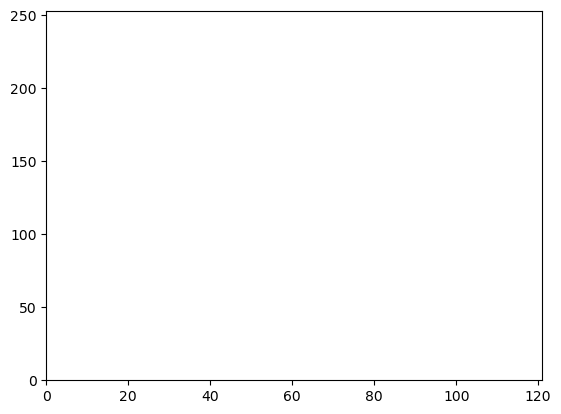

In [26]:
plt.pcolormesh(ssh_bm[0,:,:])